In [ ]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [47]:
import tensorflow as tf
import skimage.io as skio
import scipy.io as sio
from collections import Counter
from PIL import Image
import cv2
import numpy as np

import sys
sys.path.insert(0,'../')
sys.path.insert(0,'../processing/')
from datasets import sythtextprovider

slim = tf.contrib.slim

In [42]:
fish_mat = sio.loadmat('../data/train/ALB_label.mat')

[[824 286 117 123]
 [642 404 128 220]]
(720, 1280, 3)


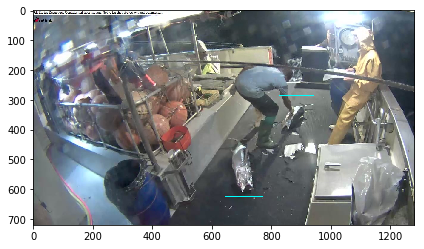

In [32]:
test = fish_mat['ALB']
print str(test[0,1][0][0])
print test[0,1][1]
img = skio.imread(str(test[0,1][0][0]))
visualize_bbox(img,test[0,1][1] )

In [55]:
def visualize_bbox(image, bboxes,type=1):
    """
    Input: image (height, width, channels)
           bboxes (numof bboxes, 4) in order(ymin, xmin, ymax, xmax)
                  range(0,1) 
    """
    numofbox = bboxes.shape[0]
    width = image.shape[1]
    height = image.shape[0]
    if type == 1:
        xmin = [i for i in bboxes[:,0]]
        ymin = [i for i in bboxes[:,1]]
        w = [i for i in bboxes[:,2]]
        h = [i for i in bboxes[:,3]]

        for i in range(numofbox):
            dst_image = cv2.rectangle(image,(xmin[i],ymin[i]),
                                 (xmin[i]+w[i],ymin[i]+h[i]),(0,255,255))
    else:
        xmin = [int(i * width) for i in bboxes[:,1]]
        ymin = [int(i * height) for i in bboxes[:,0]]
        ymax = [int(i * height) for i in bboxes[:,2]]
        xmax = [int(i * width) for i in bboxes[:,3]]

        for i in range(numofbox):
            dst_image = cv2.rectangle(image,(xmin[i],ymin[i]),
                                 (xmax[i],ymax[i]),(255,0,0))
    skio.imshow(dst_image)
    skio.show()

file_path: ../data/*.tfrecord


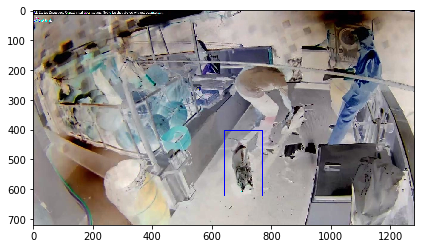

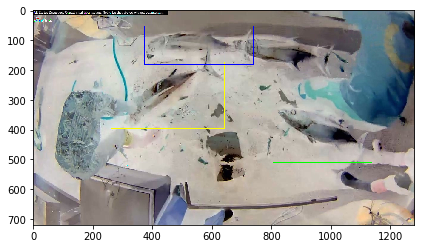

In [69]:
with tf.Graph().as_default(): 

    ## dataset provider
    dataset = sythtextprovider.get_datasets('../data/',file_pattern='*.tfrecord')
    
    data_provider = slim.dataset_data_provider.DatasetDataProvider(
            dataset, common_queue_capacity=32, common_queue_min=2)
    
    [image, shape, label, bbox] = \
    data_provider.get(['image', 'shape',
                     'object/label',
                     'object/bbox'])
    image = tf.cast(image, tf.float32) 
    bbox_image = tf.image.draw_bounding_boxes(tf.expand_dims(image,0), tf.expand_dims(bbox,0))
    
    with tf.Session() as sess: 
        sess.run(tf.global_variables_initializer())
        with slim.queues.QueueRunners(sess):
            for i in xrange(2):
                img, shape_, label_, bbox_,bbox_image_ = \
                sess.run([image, shape, label, bbox,bbox_image])
                skio.imshow(np.uint8(bbox_image_[0,:,:,:])*255)
                skio.show()